# Script de Avaliação de Modelos


#### Objetivos

- Carregamento de dados
  - Carregar corretamente as imagens de teste
  - Obter corretamente os labels de teste a partir dos nomes das pastas dos arquivos
  
- Carregamento do modelo treinado no Teachable Machine
  - Carregar metadados do modelo treinado:
    - número de épocas de treinamento
    - learning rate utilizado no treinamento
    - tamanho do batch utilizado no treinamento

- Avaliação dos modelos carregados
  - Avaliar a acurácia dos modelos carregados nos dados de teste
  - Selecionar os melhores modelos
  - Obter gráficos para investigar a relação entre as variáveis de treinamento e a acurácia obtida

In [1]:
!cat ../model/labels.txt

0 COLHER DE SOBREMESA
1 FACA DE COZINHA
2 GARFO DE JANTAR
3 CONCHA
4 ESPÁTULA DE PEIXE
5 FACA DE JANTAR
6 FACA DE PÃO
7 ABRIDOR DE GARRAFAS


In [2]:
import os
from PIL import Image

def load_labels(label_file_path):
    labels = {}
    with open(label_file_path, 'r') as file:
        for line in file:
            index, class_name = line.strip().split(' ', 1)
            labels[class_name] = int(index)
    return labels

labels = load_labels('../model/labels.txt')
labels

{'COLHER DE SOBREMESA': 0,
 'FACA DE COZINHA': 1,
 'GARFO DE JANTAR': 2,
 'CONCHA': 3,
 'ESPÁTULA DE PEIXE': 4,
 'FACA DE JANTAR': 5,
 'FACA DE PÃO': 6,
 'ABRIDOR DE GARRAFAS': 7}

In [3]:
index_to_labels = {v:k for k, v in labels.items()}
index_to_labels

{0: 'COLHER DE SOBREMESA',
 1: 'FACA DE COZINHA',
 2: 'GARFO DE JANTAR',
 3: 'CONCHA',
 4: 'ESPÁTULA DE PEIXE',
 5: 'FACA DE JANTAR',
 6: 'FACA DE PÃO',
 7: 'ABRIDOR DE GARRAFAS'}

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image, ImageOps
from keras.models import load_model

def preprocess_images(images, target_size=(224, 224)):
    """Preprocess a list of images to the required size and normalize them."""
    image_arrays = []
    for image in images:
        image = ImageOps.fit(image, target_size, Image.Resampling.LANCZOS)
        image_array = np.asarray(image)
        normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
        image_arrays.append(normalized_image_array)
    return np.stack(image_arrays, axis=0)

def predict_image_classes(model, image_arrays):
    """Predict the classes of images using the loaded model."""
    predictions = model.predict(image_arrays)
    indices = np.argmax(predictions, axis=1)
    return indices, predictions

def calculate_metrics(model, images, true_labels, verbose=0):
    """Calculate accuracy, precision, recall, and F1 score for the given model and dataset."""
    # Preprocess images in batch
    image_arrays = preprocess_images(images)
    
    # Predict classes in batch
    predictions, _ = predict_image_classes(model, image_arrays)
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    if verbose:
        for image, index in zip(images, predictions):
            print("Predicted class:", index_to_labels[index])
            display(image.resize((100, 100)))
    
    return accuracy, precision, recall, f1

def load_keras_model(model_path):
    """Load the Keras model from the specified path."""
    return load_model(model_path, compile=False)

def load_images_from_folder(folder_path, labels):
    images = []
    labels_list = []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            label_index = labels.get(class_name)
            if label_index is not None:
                for image_name in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, image_name)
                    try:
                        image = Image.open(image_path)
                        image = image.resize((224, 224))
                        images.append(image)
                        labels_list.append(label_index)
                    except IOError:
                        print(f"Error loading image {image_path}")
    return images, labels_list

def get_images_and_labels(data_folder_path, label_file_path):
    labels = load_labels(label_file_path)
    images, labels_list = load_images_from_folder(data_folder_path, labels)
    return images, labels_list


2024-09-18 00:02:13.402732: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 00:02:13.440543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 00:02:14.122351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Example usage
images, labels_list = get_images_and_labels('../data_test', '../model/labels.txt')
model_path = "../model/keras_model_50_001_16.h5"

model = load_keras_model(model_path)
accuracy, precision, recall, f1 = calculate_metrics(model, images, labels_list)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

2024-09-18 00:02:20.827588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 00:02:20.883560: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3/3 [==============================] - 1s 65ms/step
Accuracy: 0.8205128205128205
Precision: 0.8175612848689772
Recall: 0.8205128205128205
F1 Score: 0.8178507063574937


In [16]:
model.summary(expand_nested=True, show_trainable=True)

Model: "sequential_48"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_45 (Sequential)  (None, 1280)              410208    Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| model12 (Functional)      (None, 7, 7, 1280)        410208    Y          |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| input_1 (InputLayer)    [(None, 224, 224, 3)]     0         Y          ||
||                                                                        ||
|| Conv1_pad (ZeroPadding2D)  (None, 225, 225, 3)    0         Y          ||
||                                                                        ||
|| Conv1 (Conv2D)          (None, 112, 112, 16)      432       Y          ||
||                                                                        ||
|| bn_Conv1 (BatchNormalizatio  (None, 112, 112, 16) 

In [14]:
import glob
import pandas as pd


# Function to extract model information from the filename
def extract_model_info(filename):
    parts = filename.split("_")
    epochs = int(parts[2])
    learning_rate = float("0." + parts[3])
    batch_size = int(parts[4].split(".")[0])
    return epochs, learning_rate, batch_size


# Get all model files with .h5 extension
model_files = glob.glob("../model/*.h5")

# Loop through each model file, load the model, and print info and metrics
best_accuracy = -np.inf
best_model = None
best_model_file = None
best_model_info = None

model_info_list = []

for model_file in model_files:
    # Extract model information from the filename
    epochs, learning_rate, batch_size = extract_model_info(model_file.split("/")[-1])

    # Load the model
    model = load_keras_model(model_file)

    # Print model information
    print(f"Model: {model_file}")
    print(f"Epochs: {epochs}, Learning Rate: {learning_rate}, Batch Size: {batch_size}")

    # Calculate and print metrics
    accuracy, precision, recall, f1 = calculate_metrics(model, images, labels_list)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\n")

    # Append model information to the list
    model_info_list.append(
        {
            "Model File": model_file,
            "Epochs": epochs,
            "Learning Rate": learning_rate,
            "Batch Size": batch_size,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_file = model_file
        best_model_info = (epochs, learning_rate, batch_size)
df = pd.DataFrame(model_info_list)

print(f"Best model: {best_model_file}")
print(
    f"Epochs: {best_model_info[0]}, Learning Rate: {best_model_info[1]}, Batch Size: {best_model_info[2]}"
)
print(f"Final acc: {best_accuracy}")

Model: ../model/converted_keras_50_001_32.h5
Epochs: 50, Learning Rate: 0.001, Batch Size: 32
3/3 [==============================] - 1s 66ms/step
Accuracy: 0.8846153846153846
Precision: 0.9010198135198135
Recall: 0.8846153846153846
F1 Score: 0.8853115695220959


Model: ../model/converted_keras_75_002_16.h5
Epochs: 75, Learning Rate: 0.002, Batch Size: 16
3/3 [==============================] - 1s 59ms/step
Accuracy: 0.8717948717948718
Precision: 0.8801336839798378
Recall: 0.8717948717948718
F1 Score: 0.872748685660145


Model: ../model/converted_keras_75_001_16.h5
Epochs: 75, Learning Rate: 0.001, Batch Size: 16
3/3 [==============================] - 1s 60ms/step
Accuracy: 0.8974358974358975
Precision: 0.9014041514041514
Recall: 0.8974358974358975
F1 Score: 0.8979933110367893


Model: ../model/converted_keras_25_002_16.h5
Epochs: 25, Learning Rate: 0.002, Batch Size: 16
3/3 [==============================] - 1s 60ms/step
Accuracy: 0.8589743589743589
Precision: 0.8697265697265697
Recall:

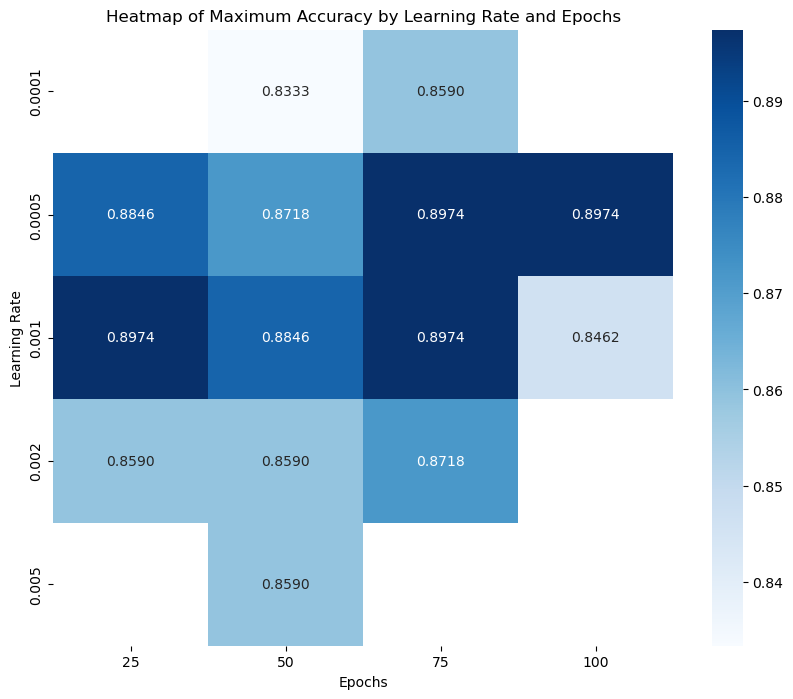

In [15]:
import seaborn as sns

import matplotlib.pyplot as plt

# Pivot the dataframe to get the maximum accuracy for each combination of learning_rate and epochs
heatmap_data = df.pivot_table(index='Learning Rate', columns='Epochs', values='Accuracy', aggfunc='max')

# Create the heatmap with a single color pattern
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".4f")
plt.title('Heatmap of Maximum Accuracy by Learning Rate and Epochs')
plt.show()

In [8]:

# train_images, train_labels = get_images_and_labels('../data_train', '../model/labels.txt')  # Load your training data


In [9]:
# from random import shuffle
# import numpy as np
# from keras.models import Model
# from keras.layers import Input
# from keras.optimizers import Adam
# from keras.models import load_model
# from PIL import Image, ImageOps


# def extract_model_architecture(model):
#     """Extract architecture from the existing model."""
#     model_json = model.to_json()
#     return model_json

# def create_new_model(model_json):
#     """Create a new model from the extracted architecture with random weights."""
#     from keras.models import model_from_json
#     new_model = model_from_json(model_json)
#     return new_model

# def compile_model(model, learning_rate=0.001):
#     """Compile the model with the Adam optimizer and a default loss function and metrics."""
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer,
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# def initialize_with_random_weights(model):
#     """Initialize model weights with random values."""
#     for layer in model.layers:
#         if hasattr(layer, 'kernel_initializer'):
#             layer.kernel_initializer = 'random_uniform'
#         if hasattr(layer, 'bias_initializer'):
#             layer.bias_initializer = 'zeros'
#     model.build(model.input_shape)
#     return model

# def train_new_model(model, train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2):
#     """Train the new model with provided training data."""
#     # Train the new model
#     history = model.fit(train_images, train_labels,
#                         epochs=epochs,
#                         batch_size=batch_size,
#                         shuffle=True,
#                         validation_split=validation_split)
#     return history

# def create_and_train_model(existing_model_path, train_images, train_labels, epochs=10, batch_size=32):
#     """Full process to create, initialize, compile, and train a new model."""
#     # Load the existing model
#     existing_model = load_model(existing_model_path, compile=False)  # No compile during loading
    
#     # Extract and create a new model with the same architecture
#     model_json = extract_model_architecture(existing_model)
#     new_model = create_new_model(model_json)
    
#     # Initialize new model with random weights
#     new_model = initialize_with_random_weights(new_model)
    
#     # Compile the new model
#     new_model = compile_model(new_model)
    
#     images_array = preprocess_images(train_images)
    
#     # Train the new model
#     history = train_new_model(new_model, images_array, np.array(train_labels), epochs=epochs, batch_size=batch_size)
    
#     return new_model, history
# # Example usage:
# # existing_model_path = 'path_to_existing_model.h5'
# # train_images, train_labels = load_training_data()  # Load your training data
# # new_model, history = create_and_train_model(existing_model_path, train_images, train_labels)


In [ ]:
# new_model, history = create_and_train_model(model_path, train_images, train_labels, batch_size=16, epochs=10)


In [ ]:
# # Evaluate the new model
# new_accuracy, new_precision, new_recall, new_f1 = calculate_metrics(new_model, images, labels_list)

# print(f"New Model Accuracy: {new_accuracy}")
# print(f"New Model Precision: {new_precision}")
# print(f"New Model Recall: {new_recall}")
# print(f"New Model F1 Score: {new_f1}")